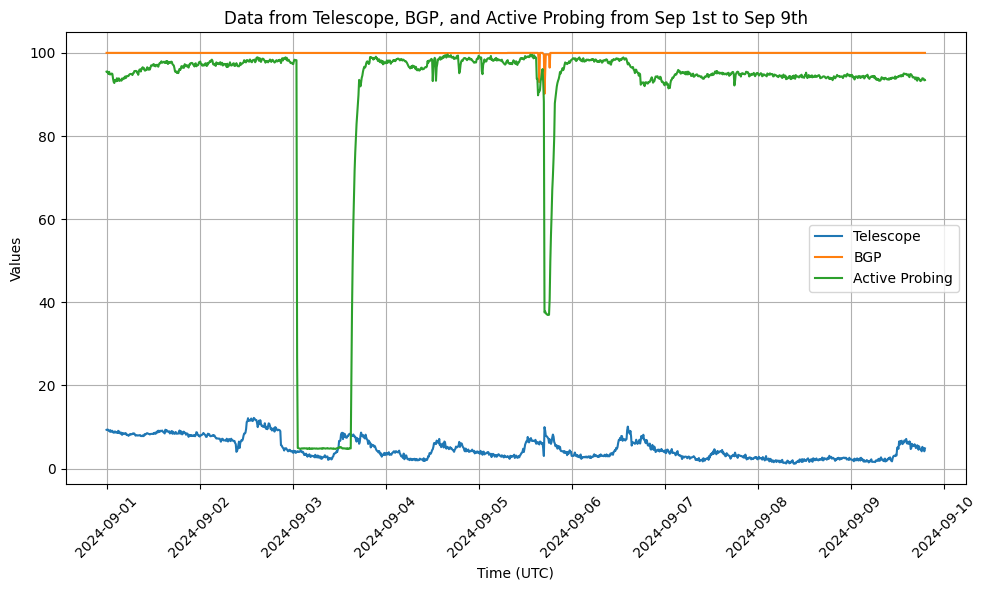

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data
data = pd.read_csv('../result/ioda/as8048.csv', parse_dates=['Time (UTC)'])

# Filter the data for the specified time range
mask = (data['Time (UTC)'] >= '2024-09-01 00:00:00') & (data['Time (UTC)'] <= '2024-09-09 23:59:00')
filtered_data = data.loc[mask]

# Plotting each category
plt.figure(figsize=(10, 6))
plt.plot(filtered_data['Time (UTC)'], filtered_data['Telescope (# Unique Source IPs)'], label='Telescope')
plt.plot(filtered_data['Time (UTC)'], filtered_data['BGP (#Visible /24s)'], label='BGP')
plt.plot(filtered_data['Time (UTC)'], filtered_data['Active Probing (#/24s Up)'], label='Active Probing')
plt.xlabel('Time (UTC)')
plt.ylabel('Values')
plt.title('Data from Telescope, BGP, and Active Probing from Sep 1st to Sep 9th')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

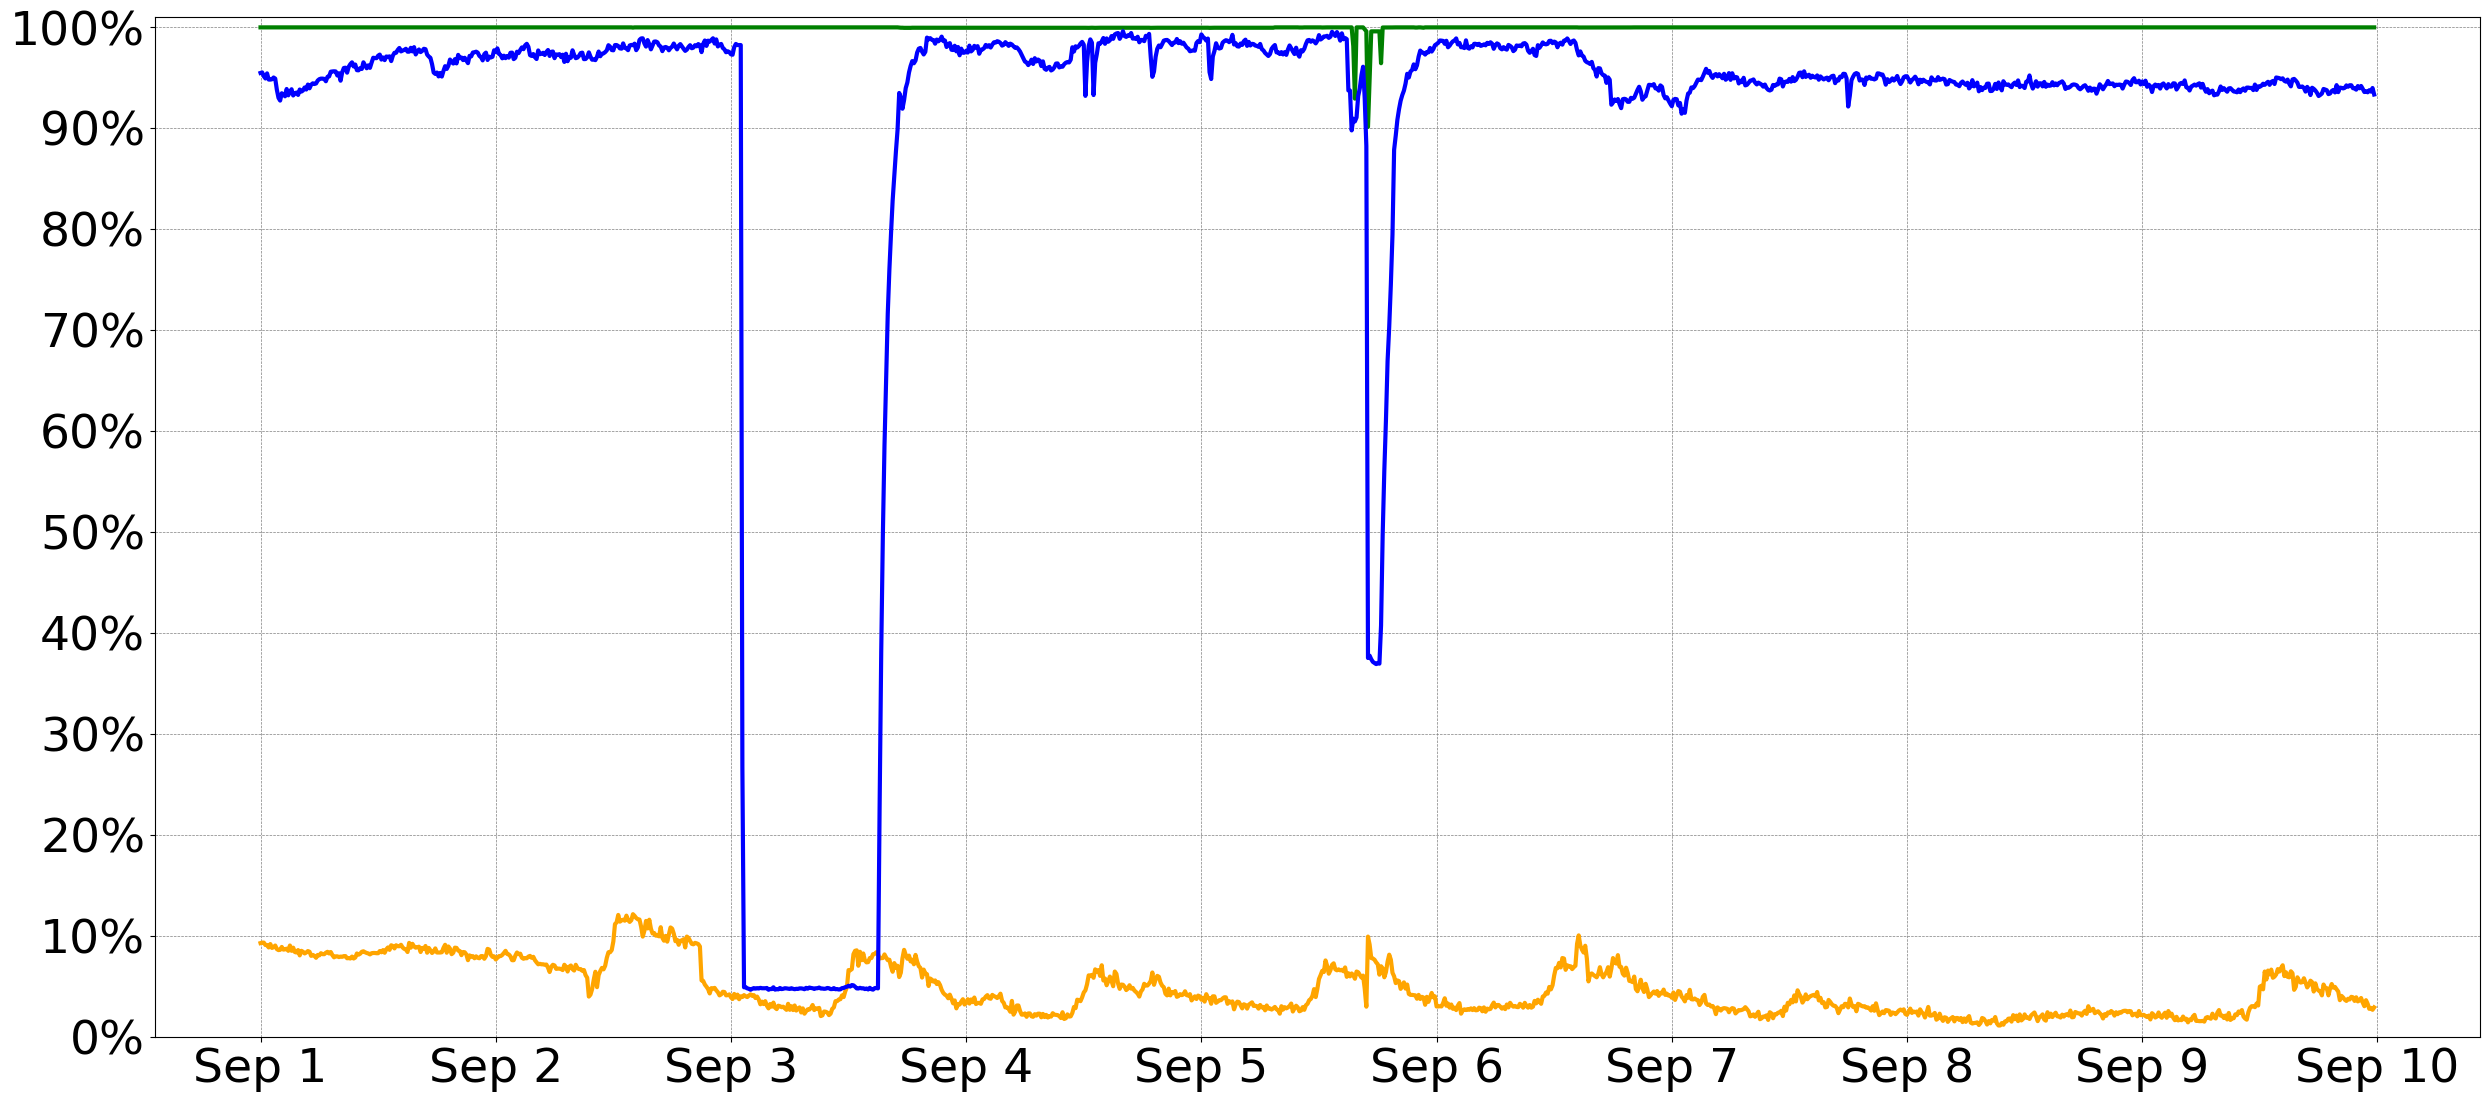

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the CSV data
data = pd.read_csv('../result/ioda/as8048.csv')
data['Time (UTC)'] = pd.to_datetime(data['Time (UTC)'])

# Filter the data
filtered_data = data[(data['Time (UTC)'] >= '2024-09-01 00:00:00') & (data['Time (UTC)'] <= '2024-09-09 23:59:00')]

# Create the plot
fig, ax = plt.subplots(figsize=(30, 15))

# Plot each line with specific colors
ax.plot(filtered_data['Time (UTC)'], filtered_data['Telescope (# Unique Source IPs)'], label='Telescope', color='orange', linestyle='-', linewidth=3)
ax.plot(filtered_data['Time (UTC)'], filtered_data['BGP (#Visible /24s)'], label='BGP', color='green', linestyle='-', linewidth=3)
ax.plot(filtered_data['Time (UTC)'], filtered_data['Active Probing (#/24s Up)'], label='Active Probing', color='blue', linestyle='-', linewidth=3)

# Set the y-axis to display percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))
ax.set_ylim(0, 101)
ax.set_yticks(range(0, 101, 10))
ax.tick_params(axis='y', labelsize=34)

# Set the x-axis format without leading zeros
date_format = mdates.DateFormatter('Sep %#d' if plt.get_backend() == 'TkAgg' else 'Sep %-d')
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(date_format)

ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray')

# Rotate x-axis labels for better readability
plt.xticks(rotation=180)

# Force matplotlib to redraw the figure
fig.autofmt_xdate()
ax.tick_params(axis='x', which='major', labelrotation=0, labelsize=34)

# Adjust x-tick labels position
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')  # adjust the horizontal position
    label.set_x(-0.03)  # adjust space to move the label right

# Show plot
plt.show()

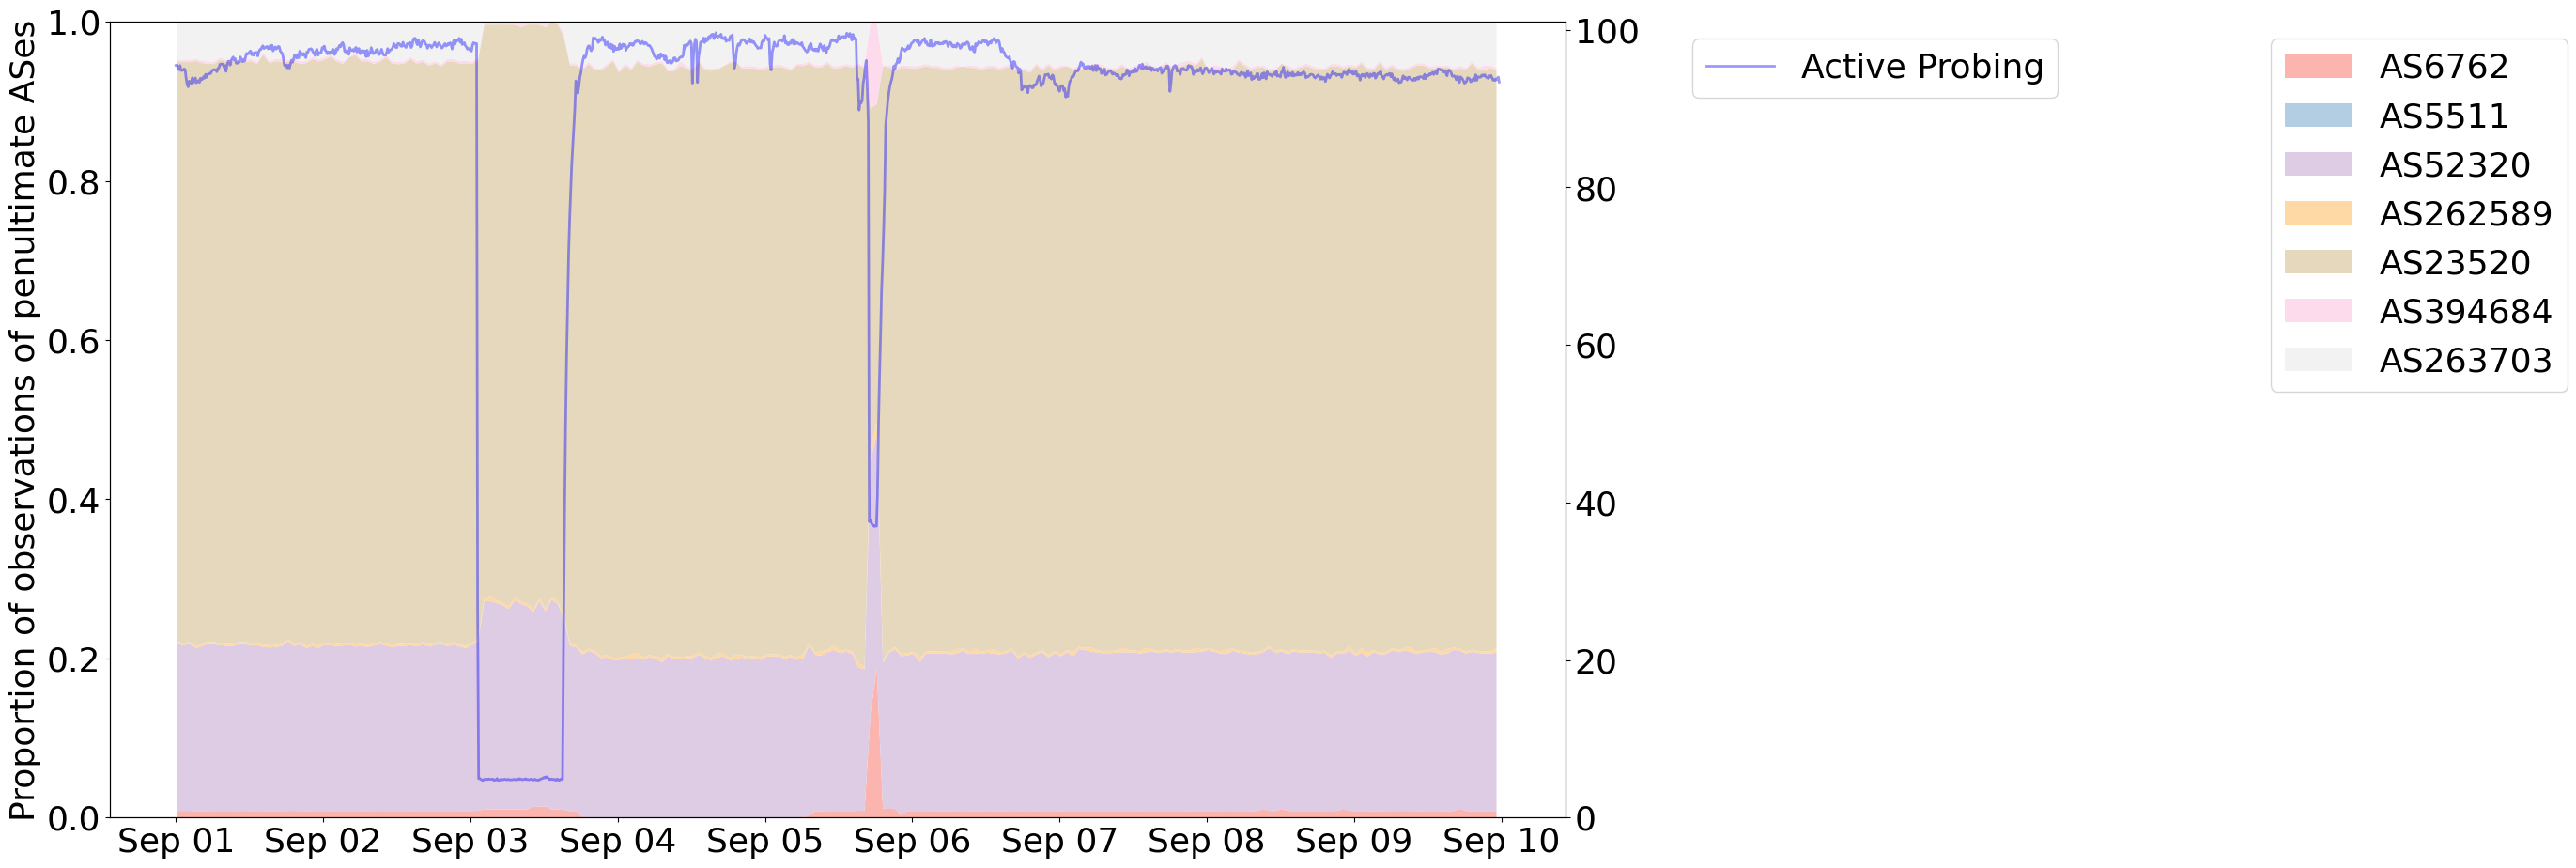

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import json
from collections import defaultdict
import numpy as np
from datetime import datetime

# Function to process JSON file for the stacked area plot
def process_file(file_path, as_numbers, originAS=8405):
    result = defaultdict(int)
    try:
        with open(file_path, 'r') as file:
            for line in file:
                entry = json.loads(line)
                if 'as_path' in entry and len(entry['as_path']) >= 2:
                    as_path = entry['as_path']
                    if originAS in as_path:
                        origin_index = len(as_path) - 1 - as_path[::-1].index(originAS)
                        if origin_index > 0:
                            last_as_before_origin = as_path[origin_index - 1]
                            if last_as_before_origin in as_numbers:
                                result[last_as_before_origin] += 1
                    else:
                        if as_path[-1] in as_numbers:
                            result[as_path[-1]] += 1
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
    return result

# Function to aggregate JSON data for the stacked area plot
def aggregate_data(base_path, as_numbers, target):
    data = {}
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(f'{target}.json'):
                    file_path = os.path.join(folder_path, filename)
                    result = process_file(file_path, as_numbers, target)
                    if folder_name in data:
                        for key in result:
                            data[folder_name][key] += result[key]
                    else:
                        data[folder_name] = result
    return data

# Function to plot stacked area chart with superimposed IODA data
def plot_combined_data(ioda_data, json_data, as_numbers, target):
    # Prepare IODA data
    ioda_data['Time (UTC)'] = pd.to_datetime(ioda_data['Time (UTC)'])
    filtered_ioda_data = ioda_data[(ioda_data['Time (UTC)'] >= '2024-09-01') & (ioda_data['Time (UTC)'] <= '2024-09-10')]

    # Prepare JSON data for stacked area plot
    timestamps = sorted(json_data.keys(), key=lambda x: datetime.strptime(f"2024-{x}", "%Y-%B-%d-%H-%M"))
    datetime_objects = [datetime.strptime(f"2024-{time}", "%Y-%B-%d-%H-%M") for time in timestamps]
    total_counts = [sum(json_data[time].values()) for time in timestamps]
    normalized_data = {as_num: [json_data[time].get(as_num, 0) / total if total > 0 else 0 for time, total in zip(timestamps, total_counts)] for as_num in as_numbers}
    stack_data = [normalized_data[as_num] for as_num in as_numbers]

    # Set up color map for stacked area chart
    cmap = plt.get_cmap('Pastel1')  # or any other visually appealing colormap
    colors = cmap(np.linspace(0, 1, len(as_numbers)))

    # Plotting
    fig, ax1 = plt.subplots(figsize=(20, 11))
    ax2 = ax1.twinx()  # Create another y-axis that shares the same x-axis

    # Plotting stacked area chart on ax1
    ax1.stackplot(datetime_objects, *stack_data, labels=[f'AS{as_num}' for as_num in as_numbers], colors=colors)
    ax1.set_ylabel('Proportion of observations of penultimate ASes', fontsize=26)
    ax1.set_ylim(0, 1)  # Normalize the left axispfor the stacked area plot
    ax1.tick_params(axis='y', labelsize=26)

    # Plotting IODA line plots on ax2 with transparency
    line_alpha = 0.4  # Transparency setting for IODA lines
    #ax2.plot(filtered_ioda_data['Time (UTC)'], filtered_ioda_data['Telescope (# Unique Source IPs)'], label='Telescope', color='orange', linestyle='-', linewidth=2, alpha=line_alpha)
    #ax2.plot(filtered_ioda_data['Time (UTC)'], filtered_ioda_data['BGP (#Visible /24s)'], label='BGP', color='green', linestyle='-', linewidth=2, alpha=line_alpha)
    ax2.plot(filtered_ioda_data['Time (UTC)'], filtered_ioda_data['Active Probing (#/24s Up)'], label='Active Probing', color='blue', linestyle='-', linewidth=2, alpha=line_alpha)
    # ax2.set_ylabel('Number of Observations', fontsize=20)
    ax2.set_ylim(0, 101)  # Adjust as needed
    ax2.tick_params(axis='y', labelsize=26)

    # Format the x-axis
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('Sep %d'))
    # ax1.set_xlabel('Time', fontsize=20)
    ax1.tick_params(axis='x', labelsize=26)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.7, 1), fontsize=26)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.35, 1),fontsize=26)

    plt.xticks(rotation=45)

    plt.show()

# Remaining parts of the script would be unchanged

# Load IODA CSV data
ioda_data = pd.read_csv('../result/ioda/as8048.csv')

# Specify base path and target AS for JSON data
base_path = "../result/vene"
target = "8048"
as_numbers = ["6762", "5511", "52320", "262589", "23520", "394684", "263703"]
json_data = aggregate_data(base_path, as_numbers, target)

# Plot combined data
plot_combined_data(ioda_data, json_data, as_numbers, target)

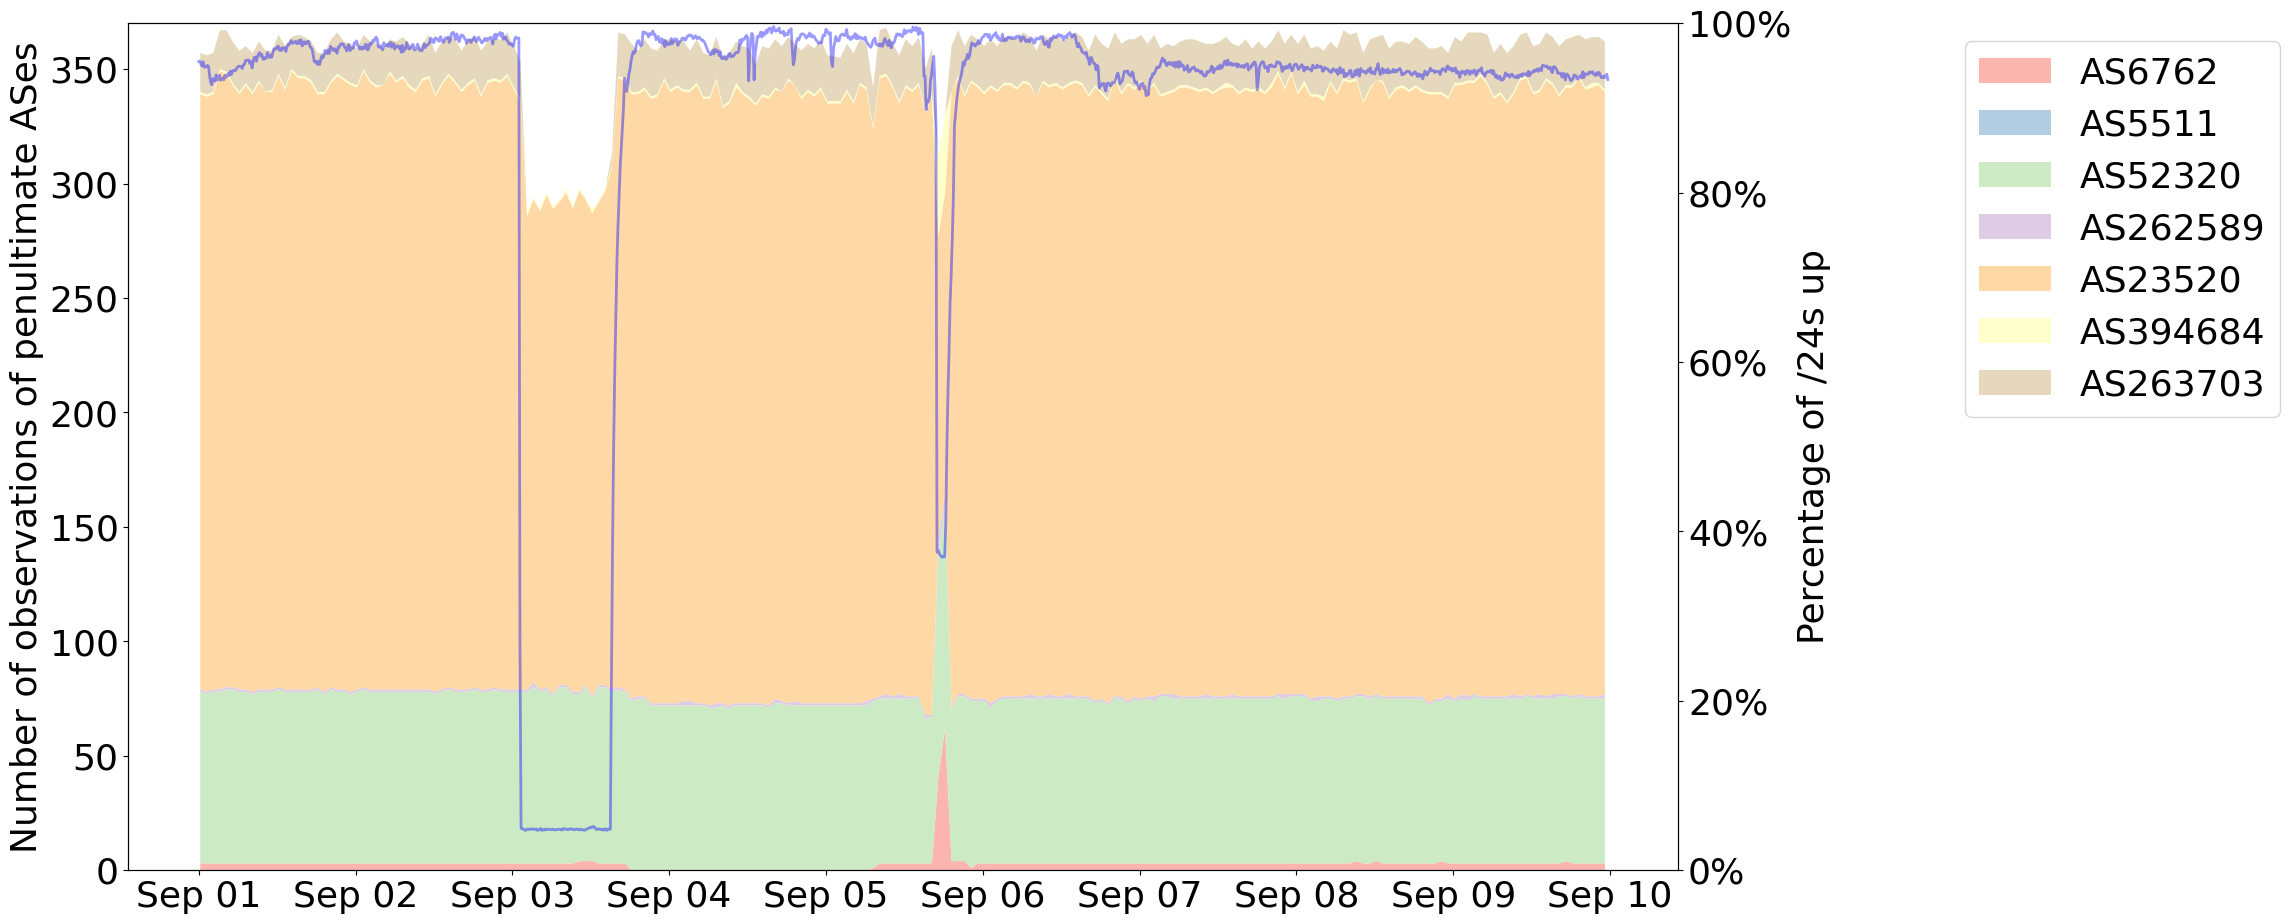

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import json
from collections import defaultdict
import numpy as np
from datetime import datetime

# Function to process JSON file for the stacked area plot
def process_file(file_path, as_numbers, originAS=8405):
    result = defaultdict(int)
    try:
        with open(file_path, 'r') as file:
            for line in file:
                entry = json.loads(line)
                if 'as_path' in entry and len(entry['as_path']) >= 2:
                    as_path = entry['as_path']
                    if originAS in as_path:
                        origin_index = len(as_path) - 1 - as_path[::-1].index(originAS)
                        if origin_index > 0:
                            last_as_before_origin = as_path[origin_index - 1]
                            if last_as_before_origin in as_numbers:
                                result[last_as_before_origin] += 1
                    else:
                        if as_path[-1] in as_numbers:
                            result[as_path[-1]] += 1
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
    return result

# Function to aggregate JSON data for the stacked area plot
def aggregate_data(base_path, as_numbers, target):
    data = {}
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(f'{target}.json'):
                    file_path = os.path.join(folder_path, filename)
                    result = process_file(file_path, as_numbers, target)
                    if folder_name in data:
                        for key in result:
                            data[folder_name][key] += result[key]
                    else:
                        data[folder_name] = result
    return data

def plot_combined_data(ioda_data, json_data, as_numbers, target):
    # Prepare IODA data
    ioda_data['Time (UTC)'] = pd.to_datetime(ioda_data['Time (UTC)'])
    filtered_ioda_data = ioda_data[(ioda_data['Time (UTC)'] >= '2024-09-01') & (ioda_data['Time (UTC)'] <= '2024-09-10')]

    # Prepare JSON data for stacked area plot
    timestamps = sorted(json_data.keys(), key=lambda x: datetime.strptime(f"2024-{x}", "%Y-%B-%d-%H-%M"))
    datetime_objects = [datetime.strptime(f"2024-{time}", "%Y-%B-%d-%H-%M") for time in timestamps]
    # Remove normalization and use absolute counts
    stack_data = [[json_data[time].get(as_num, 0) for time in timestamps] for as_num in as_numbers]

    # Set up color map for stacked area chart
    cmap = plt.get_cmap('Pastel1')  # or any other visually appealing colormap
    colors = cmap(np.linspace(0.1, 0.75, len(as_numbers)))

    # Plotting
    fig, ax1 = plt.subplots(figsize=(20, 11))
    ax2 = ax1.twinx()  # Create another y-axis that shares the same x-axis

    # Plotting stacked area chart on ax1
    ax1.stackplot(datetime_objects, *stack_data, labels=[f'AS{as_num}' for as_num in as_numbers], colors=colors)
    ax1.set_ylabel('Number of observations of penultimate ASes', fontsize=26)
    # Set y-axis for absolute values (you might need to adjust the limit based on your data)
    ax1.set_ylim(0, 370)  # Adjust the limit to be slightly higher than the max value
    ax1.tick_params(axis='y', labelsize=26)

    # Plotting IODA line plots on ax2 with transparency
    line_alpha = 0.4  # Transparency setting for IODA lines
    # Uncomment these if needed, otherwise it will just plot Active Probing
    # ax2.plot(filtered_ioda_data['Time (UTC)'], filtered_ioda_data['Telescope (# Unique Source IPs)'], label='Telescope', color='orange', linestyle='-', linewidth=2, alpha=line_alpha)
    # ax2.plot(filtered_ioda_data['Time (UTC)'], filtered_ioda_data['BGP (#Visible /24s)'], label='BGP', color='green', linestyle='-', linewidth=2, alpha=line_alpha)
    ax2.plot(filtered_ioda_data['Time (UTC)'], filtered_ioda_data['Active Probing (#/24s Up)'], label='Active Probing', color='blue', linestyle='-', linewidth=2, alpha=line_alpha)
    ax2.set_ylabel('Percentage of /24s up', fontsize=26)
    ax2.set_ylim(0, 100)  # Ensure the y-axis only goes up to 100%
    ax2.set_yticks(range(0, 101, 20))  # Set ticks at every 20%
    ax2.set_yticklabels([f'{i}%' for i in range(0, 101, 20)])
    ax2.tick_params(axis='y', labelsize=26)

    # Format the x-axis
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('Sep %d'))
    ax1.tick_params(axis='x', labelsize=26)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.4, 1), fontsize=26)
    

    plt.xticks(rotation=45)

    plt.show()

# Remaining parts of the script would be unchanged

# Load IODA CSV data
ioda_data = pd.read_csv('../result/ioda/as8048.csv')

# Specify base path and target AS for JSON data
base_path = "../result/vene"
target = "8048"
as_numbers = ["6762", "5511", "52320", "262589", "23520", "394684", "263703"]
json_data = aggregate_data(base_path, as_numbers, target)

# Plot combined data
plot_combined_data(ioda_data, json_data, as_numbers, target)

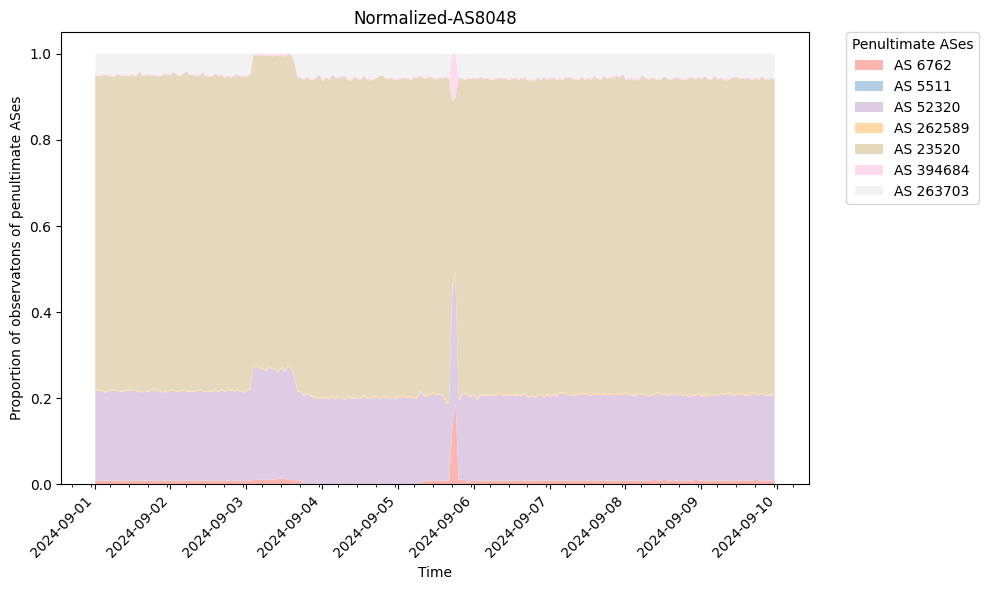

In [ ]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.dates as mdates

def process_file(file_path, as_numbers, originAS=8405):
    """Process each JSON file with multiple JSON objects (one per line).
       Count occurrences of the last AS number before the origin AS in the AS path, if the origin AS is 8405."""
    result = defaultdict(int)
    try:
        with open(file_path, 'r') as file:
            for line in file:
                try:
                    entry = json.loads(line)
                    if 'as_path' in entry and len(entry['as_path']) >= 2:
                        as_path = entry['as_path']
                        # Find the last occurrence of the origin AS and check the AS number before it
                        if originAS in as_path:
                            # Get the index of the last occurrence of the origin AS
                            origin_index = len(as_path) - 1 - as_path[::-1].index(originAS)
                            if origin_index > 0:  # Ensure there is an AS number before the origin AS
                                last_as_before_origin = as_path[origin_index - 1]
                                # Check if this AS number is in as_numbers
                                if last_as_before_origin in as_numbers:
                                    result[last_as_before_origin] += 1
                        else:
                            if as_path[-1] in as_numbers:
                                result[as_path[-1]] += 1
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON from file {file_path}: {e}")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
    return result

def aggregate_data(base_path, as_numbers, target):
    """Aggregate data from all directories under the base path for the specified AS numbers."""
    data = {}
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(f'{target}.json'):
                    file_path = os.path.join(folder_path, filename)
                    result = process_file(file_path, as_numbers, target)
                    if folder_name in data:
                        for key in result:
                            data[folder_name][key] += result[key]
                    else:
                        data[folder_name] = result
    return data


def plot_data(data, as_numbers, target):
    """Plot a normalized stacked area chart from aggregated data for specified AS numbers."""
    # Sort the timestamps and convert them to datetime objects
    timestamps = sorted(data.keys(), key=lambda x: datetime.strptime(f"2024-{x}", "%Y-%B-%d-%H-%M"))
    datetime_objects = [datetime.strptime(f"2024-{time}", "%Y-%B-%d-%H-%M") for time in timestamps]

    # Calculate total counts for each timestamp to normalize data
    total_counts = [sum(data[time].values()) for time in timestamps]

    # Extract individual AS counts and normalize them
    normalized_data = {as_num: [data[time].get(as_num, 0) / total if total > 0 else 0 for time, total in zip(timestamps, total_counts)] for as_num in as_numbers}

    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = plt.get_cmap('Pastel1')  # Using a pastel color map
    colors = cmap(np.linspace(0, 1, len(as_numbers)))  # Generate colors for each AS number

    # Prepare data for stackplot
    stack_data = [normalized_data[as_num] for as_num in as_numbers]
    labels = [f'AS {as_num}' for as_num in as_numbers]

    # Plot the stackplot
    ax.stackplot(datetime_objects, *stack_data, labels=labels, colors=colors)

    # Set the x-axis date formatting
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    ax.set_xlabel('Time')
    ax.set_ylabel('Proportion of observatons of penultimate ASes')
    ax.set_title(f'Normalized-AS{target}')
    ax.legend(title='Penultimate ASes', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# List of AS numbers to track
as_numbers = ["6762", "5511", "52320", "262589", "23520", "394684", "263703"]

# Main execution
if __name__ == "__main__":
    base_path = "../result/vene" 
    target = "8048"
    aggregated_data = aggregate_data(base_path, as_numbers, target)

    plot_data(aggregated_data, as_numbers, target)